### Bot Detection using Digital DNA Compression

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp "/content/drive/MyDrive/Cresci17/cresci-2017.csv.zip" "data.zip"
!cp "/content/drive/MyDrive/TwiBot-20/Twibot-20.zip" "data1.zip"
!unzip data1.zip
!unzip data.zip
!unzip /content/datasets_full.csv/crowdflower_results.csv.zip
!unzip /content/datasets_full.csv/fake_followers.csv.zip
!unzip /content/datasets_full.csv/genuine_accounts.csv.zip
!unzip /content/datasets_full.csv/social_spambots_1.csv.zip
!unzip /content/datasets_full.csv/social_spambots_2.csv.zip
!unzip /content/datasets_full.csv/social_spambots_3.csv.zip
!unzip /content/datasets_full.csv/social_spambots_4.csv.zip
!unzip /content/datasets_full.csv/traditional_spambots_1.csv.zip
!unzip /content/datasets_full.csv/traditional_spambots_2.csv.zip
!unzip /content/datasets_full.csv/traditional_spambots_3.csv.zip
!unzip /content/datasets_full.csv/traditional_spambots_4.csv.zip

Archive:  data1.zip
   creating: Twibot-20/
  inflating: Twibot-20/dev.json      
  inflating: Twibot-20/LICENSE       
  inflating: Twibot-20/README.txt    
  inflating: Twibot-20/support.json  
  inflating: Twibot-20/test.json     
  inflating: Twibot-20/train.json    
  inflating: Twibot-20/TwiBot-20 Seed Users.txt  
Archive:  data.zip
   creating: datasets_full.csv/
  inflating: datasets_full.csv/crowdflower_results.csv.zip  
  inflating: datasets_full.csv/fake_followers.csv.zip  
  inflating: datasets_full.csv/genuine_accounts.csv.zip  
  inflating: datasets_full.csv/social_spambots_1.csv.zip  
  inflating: datasets_full.csv/social_spambots_2.csv.zip  
  inflating: datasets_full.csv/social_spambots_3.csv.zip  
  inflating: datasets_full.csv/traditional_spambots_1.csv.zip  
  inflating: datasets_full.csv/traditional_spambots_2.csv.zip  
  inflating: datasets_full.csv/traditional_spambots_3.csv.zip  
  inflating: datasets_full.csv/traditional_spambots_4.csv.zip  
  inflating: READ.M

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [6]:
import random
import sys
import time
import zlib

In [7]:
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
from scipy.stats import ttest_1samp

<hr>

### Digital DNA

Model account behaviour by defining the following alphabet, of cardinality N = 3,

$B^3_{type} = {\{A, C, T\}}$

A $\leftarrow$ tweet,

C $\leftarrow$ reply,

T $\leftarrow$ retweet

<hr>

#### Datasets

User profile data.

In [8]:
### Users

# Genuine accounts.
gen = pd.read_csv('/content/genuine_accounts.csv/users.csv')

# Social spambots.
ss1 = pd.read_csv('/content/social_spambots_1.csv/users.csv')
ss2 = pd.read_csv('/content/social_spambots_2.csv/users.csv')
ss3 = pd.read_csv('/content/social_spambots_3.csv/users.csv')

# Traditional spambots.
ts1 = pd.read_csv('/content/traditional_spambots_1.csv/users.csv')
ts2 = pd.read_csv('/content/traditional_spambots_2.csv/users.csv')
ts3 = pd.read_csv('/content/traditional_spambots_3.csv/users.csv')
ts4 = pd.read_csv('/content/traditional_spambots_4.csv/users.csv')

Tweets.

In [9]:
### Tweets

# Genuine accounts.
gen_tweets = pd.read_csv('/content/genuine_accounts.csv/tweets.csv', sep=",", encoding='Latin-1')

# Social spambots.
ss1_tweets = pd.read_csv('/content/social_spambots_1.csv/tweets.csv', sep=",", encoding='Latin-1')
ss2_tweets = pd.read_csv('/content/social_spambots_2.csv/tweets.csv', sep=",", encoding='Latin-1')
ss3_tweets = pd.read_csv('/content/social_spambots_3.csv/tweets.csv', sep=",", encoding='Latin-1')

# Traditional spambots.
ts1_tweets = pd.read_csv('/content/traditional_spambots_1.csv/tweets.csv', sep=",", encoding='Latin-1')

<hr>

#### Digital DNA.

In [10]:
def create_dna_from_tweets(tweets_df):
    '''For each user id in tweets_df return a digital DNA string based on posting behaviour.'''
    
    # Add columns for counts of tweets, replies and retweets.
    tweets_df['num_retweets'] = np.where(tweets_df['retweeted_status_id'] == 0, 0, 1)
    tweets_df['num_replies'] = np.where(tweets_df['in_reply_to_status_id'] == 0, 0, 1)
    tweets_df['num_tweets'] = np.where((tweets_df['num_retweets'] == 0) & (tweets_df['num_replies'] == 0), 1, 0)

    # DNA alphabet for tweet (A), retweet (C) and reply (T).
    tweets = tweets_df['num_tweets'] == 1
    retweets = tweets_df['num_retweets'] == 1
    replies = tweets_df['num_replies'] == 1

    tweets_df.loc[:, 'DNA'] = np.where(retweets, 'C', np.where(replies, 'T', 'A'))

    # Sort tweets by timestamp..
    tweets_df = tweets_df[['user_id', 'timestamp', 'DNA']]
    tweets_df = tweets_df.sort_values(by=['timestamp'])
    tweets_df = tweets_df[['user_id', 'DNA']]
    #print(tweets_df)
    # Create digital DNA string for each user account.
    #print(tweets_df[tweets_df.user_id.isin(tweets_df.groupby('user_id').filter(lambda x: len(x) <= 200))])
    dna = tweets_df.groupby(by=['user_id'])['DNA'].agg(lambda x: ''.join(x))
    
    return dna

In [11]:
def compress_dna_df(dna):
    '''Return a dataframe with compression facts for a series of dna.'''

    # Convert DNA in string object to bytes object.
    dna_bytes = dna.apply(lambda s: s.encode('utf-8'))

    # Run compression on each DNA string in the sample.
    dna_compressed = dna_bytes.apply(lambda b: zlib.compress(b))

    # Create dataframe with compression facts.
    dna_df = pd.DataFrame({'dna': dna,
                           'original_dna_size': dna_bytes.apply(sys.getsizeof), 
                           'compressed_dna_size': dna_compressed.apply(sys.getsizeof)})
    
    dna_df['compression_ratio'] = dna_df['original_dna_size'] / dna_df['compressed_dna_size']
    
    return dna_df

In [12]:
gen_tweets['num_hashtags'].value_counts()

0.0     2388931
1.0      306535
2.0       90481
3.0       29026
4.0       11943
5.0        5101
6.0        2755
7.0        1709
8.0        1173
9.0         756
10.0        430
11.0        252
12.0        114
13.0         55
14.0         42
15.0         20
16.0         15
17.0          6
18.0          4
20.0          3
23.0          2
28.0          2
21.0          1
27.0          1
24.0          1
25.0          1
22.0          1
19.0          1
Name: num_hashtags, dtype: int64

In [13]:
gen_dna = create_dna_from_tweets(gen_tweets)


In [14]:
gen_dna.head()

user_id
678033.0    CAAAACAAATCCTTATCCCAAACACTCCAACATAACAAATCTTATC...
722623.0    TTTAAAAAATCAAAATATAAAAAAAAAAAAAAAATAATTTTTATTA...
755116.0    AAATTAATCATTTTTTTTTTTTTTCCATTAAACAAAAAATTATTCT...
755746.0    AATAAAAATAAAAAAAATAAATCAAAAACAAAAACATAAAAAAAAT...
785080.0    ATTAACAAAATAAATTTAATTCCCCAACTACACTAACTATTCTTTA...
Name: DNA, dtype: object

<hr>

Create DNA strings based on behaviour activity for each account.

In [15]:
gen_dna = create_dna_from_tweets(gen_tweets)

ss1_dna = create_dna_from_tweets(ss1_tweets)
ss2_dna = create_dna_from_tweets(ss2_tweets)
ss3_dna = create_dna_from_tweets(ss3_tweets)

ts1_dna = create_dna_from_tweets(ts1_tweets)

Compression on digital DNA strings.

In [16]:
gen_dna = compress_dna_df(gen_dna)

ss1_dna = compress_dna_df(ss1_dna)
ss2_dna = compress_dna_df(ss2_dna)
ss3_dna = compress_dna_df(ss3_dna)

ts1_dna = compress_dna_df(ts1_dna)

bot_dna = pd.concat([ss1_dna, ss2_dna, ss3_dna])

<hr>

#### Visualise compression facts for accounts.

In [17]:
# Add a column for account type to the dataframes.
gen_dna['Account Type'] = 'Genuine'
bot_dna['Account Type'] = 'Bot'

# Combine all samples into a single dataframe.
all_dna = pd.concat([gen_dna, bot_dna])

In [18]:
all_dna.sample(5)

,dna,original_dna_size,compressed_dna_size,compression_ratio,Account Type
user_id,,,,,
2.384976e+09,AATAATAATATAATAAATAATAATTAATAATTAATAAT,71,51,1.392157,Bot
2.351848e+09,AAAAAAAAAAAAAAAAAAAATAATAATAATAATAATAATAATAATA...,171,63,2.714286,Bot
5.311375e+08,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,3234,82,39.439024,Bot
2.266513e+09,ACAACACCACAACCCACACCCACACACACACCACAAACACAACCAC...,3223,537,6.001862,Bot
2.358181e+09,AAAAAAAAAAAAAAAAAAAAAAATAATAATAATATAAAATAATAAA...,136,62,2.193548,Bot


In [19]:
all_dna.columns

Index(['dna', 'original_dna_size', 'compressed_dna_size', 'compression_ratio',
       'Account Type'],
      dtype='object')

In [20]:
def func(x):
  ans = ''
  #print(x)
  if pd.isnull(x) == True:
    return ans
  else:
    for i in range(min(200, len(x))):
      #print(i)
      ans = ans + x[i]
    return ans

In [21]:

dna = all_dna['dna'].apply(lambda x: func(x))
all_dna.drop('dna', axis=1, inplace = True)
dna = pd.merge(left=dna, right=all_dna, how='left', on='user_id')

In [22]:
dna['Account Type'].value_counts()

Bot        4912
Genuine    1083
Name: Account Type, dtype: int64

In [23]:
dna

,dna,original_dna_size,compressed_dna_size,compression_ratio,Account Type
user_id,,,,,
6.780330e+05,CAAAACAAATCCTTATCCCAAACACTCCAACATAACAAATCTTATC...,3228,844,3.824645,Genuine
7.226230e+05,TTTAAAAAATCAAAATATAAAAAAAAAAAAAAAATAATTTTTATTA...,3234,829,3.901086,Genuine
7.551160e+05,AAATTAATCATTTTTTTTTTTTTTCCATTAAACAAAAAATTATTCT...,3242,733,4.422920,Genuine
7.557460e+05,AATAAAAATAAAAAAAATAAATCAAAAACAAAAACATAAAAAAAAT...,3267,731,4.469220,Genuine
7.850800e+05,ATTAACAAAATAAATTTAATTCCCCAACTACACTAACTATTCTTTA...,3268,771,4.238651,Genuine
...,...,...,...,...,...
2.396095e+09,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,768,48,16.000000,Bot
2.396099e+09,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,1563,53,29.490566,Bot
2.429375e+09,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,1140,51,22.352941,Bot


In [24]:
dna.drop(['original_dna_size', 'compressed_dna_size', 'compression_ratio'], axis = 1, inplace = True)
comp_stats = compress_dna_df(dna['dna'])
dna = pd.merge(left = dna, right = comp_stats, how = 'left', left_index = True, right_index = True)

##### Plot of Uncompressed DNA Size vs. Compressed DNA Size.

Includes the following accounts:
1. Genuine users
1. Social Spambots \#1
1. Social Spambots \#2
1. Social Spambots \#3
1. Traditional Spambots \#1

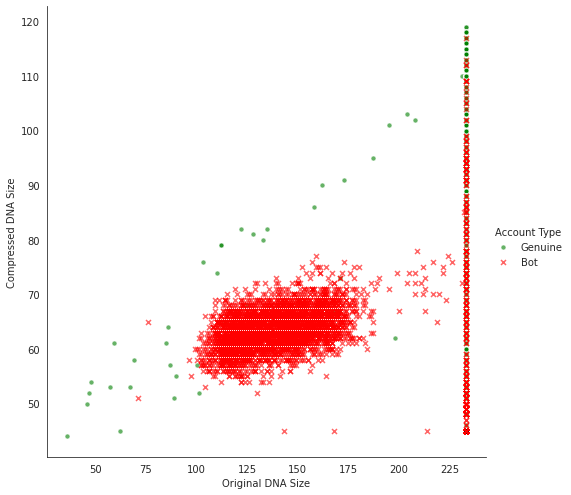

In [25]:
sns.set_style("white")

pal = {
    'Genuine': 'green',
    'Bot': 'red'
}

g = sns.FacetGrid(dna, hue='Account Type', palette=pal, size=7, hue_kws=dict(marker=["o", "x"]))
g.map(plt.scatter, "original_dna_size", "compressed_dna_size", s=25, alpha=.6, edgecolor="white")
g.add_legend()
g.set_axis_labels('Original DNA Size', 'Compressed DNA Size')

##### Plot of DNA Size vs. Compression Ratio.

Includes the following accounts:
1. Genuine users
1. Social Spambots \#1
1. Social Spambots \#2
1. Social Spambots \#3
1. Traditional Spambots \#1

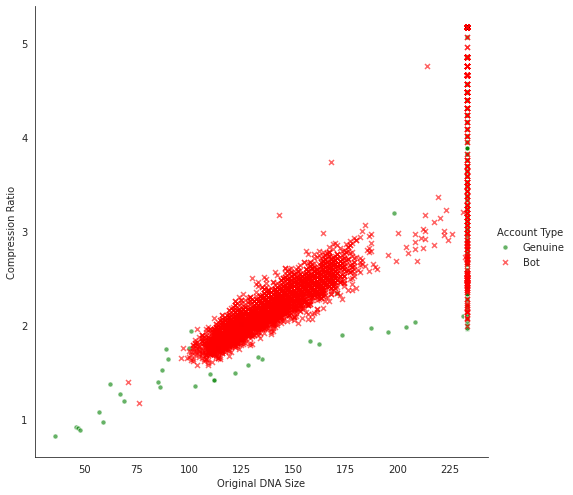

In [26]:
sns.set_style("white")

pal = {
    'Genuine': 'green',
    'Bot': 'red'
}

g = sns.FacetGrid(dna, hue='Account Type', palette=pal, size=7, hue_kws=dict(marker=["o", "x"]))
g.map(plt.scatter, "original_dna_size", "compression_ratio", s=25, alpha=.6, edgecolor="white")
g.add_legend()
g.set_axis_labels('Original DNA Size', 'Compression Ratio')

##### Historgram for Compression Ratio

Includes the following accounts:
1. Genuine users
1. Social Spambots \#1
1. Social Spambots \#2
1. Social Spambots \#3
1. Traditional Spambots \#1

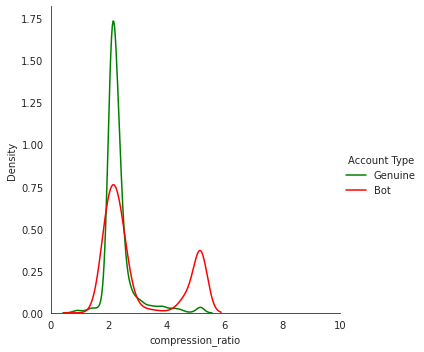

In [27]:
g = sns.FacetGrid(dna, hue='Account Type', palette=pal, size=5)
g.set(xlim=(0, 10))
g.map(sns.kdeplot, 'compression_ratio')
g.add_legend()

<hr>

Evaluation Metrics
1. Accuracy
1. Precision
1. Recall
1. F1 Score
1. Specificity
1. MCC

In [28]:
def evaluate(y_test, predictions):
    '''Return a dataframe with accuracy, precision, recall and f1 scores for predictions.'''
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    specificity = tn / (tn+fp)
    
    results = [
        {
            'Metric': 'Accuracy',
            'Score': accuracy_score(y_test, predictions)
        },
        {
            'Metric': 'Precision',
            'Score': precision_score(y_test, predictions)
        },
        {
            'Metric': 'Recall',
            'Score': recall_score(y_test, predictions)
        },
        {
            'Metric': 'F1 Score',
            'Score': f1_score(y_test, predictions)
        },
        {
            'Metric': 'MCC',
            'Score': matthews_corrcoef(y_test, predictions)
        },
        {
            'Metric': 'Specificity',
            'Score': specificity
        },
    ]

    return pd.DataFrame(results)

<hr>

In [29]:
def train_predict_evaluate(dna, features, test_size=0.5):
    '''Train a Logistic Regression model with given features
    using default parameters on a random sample of data.'''

    # Randomly shuffle the dna dataframe.
    dna = utils.shuffle(dna)

    # Features and labels.
    X = dna[features]
    y = dna.loc[:, 'label']

    # Split the dataset for training and testing using Logistic Regression.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # Logistic Regression classifier with default parameters.
    classifier = LogisticRegression()

    # Train the classifier.
    start_train = time.time()
    classifier.fit(X_train, y_train)
    end_train = time.time()

    # Make predictions on the test set.
    start_test = time.time()
    predictions = classifier.predict(X_test)
    end_test = time.time()

    # Evaluation on the test set.
    results = evaluate(y_test, predictions)

    return results

<hr>

Results for k-common substring

In [30]:
k_common_substring_1 = pd.DataFrame({'Supervised': [0.977, 0.977, 0.955, 0.982, 0.977, 0.981],
                                     'Unsupervised': [0.976, 0.977, 0.952, 0.982, 0.972, 0.981]}, 
                                    index=['Accuracy', 'F1 Score', 'MCC', 'Precision', 'Recall', 'Specificity'])


In [31]:
k_common_substring_2 = pd.DataFrame({'Supervised': [0.970, 0.970, 0.940, 0.978, 0.961, 0.979], 
                                     'Unsupervised': [0.929, 0.923, 0.867, 1.000, 0.858, 1.000]},
                                    index=['Accuracy', 'F1 Score', 'MCC', 'Precision', 'Recall', 'Specificity'])

<hr>

## Test Set #1

In [32]:
# Genuine accounts in test set 1.
gen_test1 = gen[gen['test_set_1'] == 1]

# Social spambots in test set 1.
ss1_test_1 = ss1[ss1['test_set_1'] == 1]


# Tweets for genuine accounts in test set 1.
gen_tweets_test1 = gen_tweets[gen_tweets['user_id'].isin(gen_test1['id'])]

# Tweets for spambot accounts in test set 1.
ss1_tweets_test1 = ss1_tweets[ss1_tweets['user_id'].isin(ss1_test_1['id'])]


# DNA for genuine accounts in test set 1.
gen_dna_test1 = create_dna_from_tweets(gen_tweets_test1)

# DNA for spambots in test set 1.
ss1_dna_test1 = create_dna_from_tweets(ss1_tweets_test1)


# DNA string compression for genuine accounts in test set 1.
gen_dna_test1 = compress_dna_df(gen_dna_test1)

# DNA string compression for spambots in test set 1.
ss1_dna_test1 = compress_dna_df(ss1_dna_test1)


# Add a column for label to the dataframes.
gen_dna_test1['label'] = 0
ss1_dna_test1['label'] = 1

There are some accounts for which there are no tweets, set an empty string as the DNA sequence for such accounts.

In [33]:
sys.getsizeof(''.encode('utf-8'))   # size in bytes of empty string

33

In [34]:
sys.getsizeof(zlib.compress(''.encode('utf-8')))    # size in bytes of compressed empty string

41

In [35]:
# compression ratio for empty string
sys.getsizeof(''.encode('utf-8')) / sys.getsizeof(zlib.compress(''.encode('utf-8')))

0.8048780487804879

In [36]:
gen_with_no_tweets_test1 = gen_test1[~gen_test1['id'].isin(gen_dna_test1.index)]

gen_with_no_tweets_dna_test1 = pd.DataFrame({'id': gen_with_no_tweets_test1['id'], 
                                             'original_dna_size': 33, 
                                             'compressed_dna_size': 41, 
                                             'compression_ratio': 0.80, 
                                             'label': 0})

gen_with_no_tweets_dna_test1 = gen_with_no_tweets_dna_test1.set_index('id')

gen_dna_test1 = pd.concat([gen_dna_test1, gen_with_no_tweets_dna_test1])

# Combine test set 1 accounts into a single dataframe.
dna_test1 = pd.concat([gen_dna_test1, ss1_dna_test1])

In [37]:
gen_dna_test1['label'].value_counts()


0    1000
Name: label, dtype: int64

In [38]:
ss1_dna_test1.value_counts()

dna                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [39]:
dna_test1.sample(5)

,dna,original_dna_size,compressed_dna_size,compression_ratio,label
1.424965e+09,CCCCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,1734,222,7.810811,1
5.389964e+08,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,1373,61,22.508197,1
2.665608e+08,NaN,33,41,0.800000,0
8.889373e+08,NaN,33,41,0.800000,0
2.751216e+09,NaN,33,41,0.800000,0


In [40]:
dna_test1['dna']

7.551160e+05    AAATTAATCATTTTTTTTTTTTTTCCATTAAACAAAAAATTATTCT...
7.557460e+05    AATAAAAATAAAAAAAATAAATCAAAAACAAAAACATAAAAAAAAT...
8.069750e+05    AATTAAAAATATCTCTCTTTTATAATATTTACATTACCTTACCACA...
1.813221e+06    CTTCACCCCCCCAATCATTAAAACTAATACCCACTCCAAATTCAAC...
3.873101e+06    AATAAAATAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAA...
                                      ...                        
2.286273e+09    AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
2.287319e+09    AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
2.290265e+09    AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
2.398911e+09    ACAAAAAAAAAAAAAAAAAAAACTACAAACAAACCATAAAACTAAA...
2.525273e+09    CCCCAACCACCCCCCACCCCCCCCCCACACCCCCACCCCCCCCCCC...
Name: dna, Length: 1991, dtype: object

In [41]:
dna = dna_test1['dna'].apply(lambda x: func(x))
dna

7.551160e+05    AAATTAATCATTTTTTTTTTTTTTCCATTAAACAAAAAATTATTCT...
7.557460e+05    AATAAAAATAAAAAAAATAAATCAAAAACAAAAACATAAAAAAAAT...
8.069750e+05    AATTAAAAATATCTCTCTTTTATAATATTTACATTACCTTACCACA...
1.813221e+06    CTTCACCCCCCCAATCATTAAAACTAATACCCACTCCAAATTCAAC...
3.873101e+06    AATAAAATAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAA...
                                      ...                        
2.286273e+09    AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
2.287319e+09    AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
2.290265e+09    AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
2.398911e+09    ACAAAAAAAAAAAAAAAAAAAACTACAAACAAACCATAAAACTAAA...
2.525273e+09    CCCCAACCACCCCCCACCCCCCCCCCACACCCCCACCCCCCCCCCC...
Name: dna, Length: 1991, dtype: object

In [42]:

dna_test1.drop('dna', axis=1, inplace = True)


In [43]:
dna

7.551160e+05    AAATTAATCATTTTTTTTTTTTTTCCATTAAACAAAAAATTATTCT...
7.557460e+05    AATAAAAATAAAAAAAATAAATCAAAAACAAAAACATAAAAAAAAT...
8.069750e+05    AATTAAAAATATCTCTCTTTTATAATATTTACATTACCTTACCACA...
1.813221e+06    CTTCACCCCCCCAATCATTAAAACTAATACCCACTCCAAATTCAAC...
3.873101e+06    AATAAAATAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAA...
                                      ...                        
2.286273e+09    AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
2.287319e+09    AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
2.290265e+09    AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
2.398911e+09    ACAAAAAAAAAAAAAAAAAAAACTACAAACAAACCATAAAACTAAA...
2.525273e+09    CCCCAACCACCCCCCACCCCCCCCCCACACCCCCACCCCCCCCCCC...
Name: dna, Length: 1991, dtype: object

In [44]:
dna_test1

,original_dna_size,compressed_dna_size,compression_ratio,label
7.551160e+05,3242,733,4.422920,0
7.557460e+05,3267,731,4.469220,0
8.069750e+05,3271,876,3.734018,0
1.813221e+06,3223,820,3.930488,0
3.873101e+06,3255,352,9.247159,0
...,...,...,...,...
2.286273e+09,1723,68,25.338235,1
2.287319e+09,1708,74,23.081081,1
2.290265e+09,1766,71,24.873239,1
2.398911e+09,1234,275,4.487273,1


In [45]:
dna = pd.merge(left=dna, right=dna_test1, left_index=True, right_index=True)

In [46]:
dna.head()

,dna,original_dna_size,compressed_dna_size,compression_ratio,label
755116.0,AAATTAATCATTTTTTTTTTTTTTCCATTAAACAAAAAATTATTCT...,3242,733,4.422920,0
755746.0,AATAAAAATAAAAAAAATAAATCAAAAACAAAAACATAAAAAAAAT...,3267,731,4.469220,0
806975.0,AATTAAAAATATCTCTCTTTTATAATATTTACATTACCTTACCACA...,3271,876,3.734018,0
1813221.0,CTTCACCCCCCCAATCATTAAAACTAATACCCACTCCAAATTCAAC...,3223,820,3.930488,0
3873101.0,AATAAAATAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAA...,3255,352,9.247159,0


In [47]:
dna['label'].value_counts()

0    1000
1     991
Name: label, dtype: int64

In [48]:
dna.drop(['original_dna_size', 'compressed_dna_size', 'compression_ratio'], axis = 1, inplace = True)
comp_stats = compress_dna_df(dna['dna'])
dna = pd.merge(left = dna, right = comp_stats, how = 'left', left_index = True, right_index = True)

1. Logistic Regression with Original DNA Size + Compressed DNA Size

In [49]:
results = pd.DataFrame()

for i in range(1000):
    np.random.seed(i)
    results = pd.concat([results, train_predict_evaluate(dna, ['original_dna_size', 'compressed_dna_size'])])

# Compute average scores for each metric

results_with_length = results.groupby(by=['Metric']) \
               .mean() \
               .rename({'Score': 'Mean'}, axis=1) \
               .join(results.groupby(by=['Metric'])
                            .std() \
                            .rename({'Score': 'Std.'}, axis=1))

# Compute statistical significance against the method k-common-substring for DNA sequences
stat_sig = []
for metric in k_common_substring_1.index:
    s = dict()

    ts, ps = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_1['Supervised'][metric])
    tu, pu = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_1['Unsupervised'][metric])

    s['Metric'] = metric
    s['t-supervised'] = round(ts, 4)
    s['t-unsupervised'] = round(tu, 4)
    s['p-supervised'] = round(ps, 4)
    s['p-unsupervised'] = round(pu, 4)
    s['Mean'] = results[results['Metric'] == metric]['Score'].mean()
    s['SD'] = results[results['Metric'] == metric]['Score'].std()
    s['k-supervised'] = k_common_substring_1['Supervised'][metric]
    s['k-unsupervised'] = k_common_substring_1['Unsupervised'][metric]
    
    stat_sig.append(s)

stat_sig = pd.DataFrame(stat_sig).set_index(['Metric'])

stat_sig

,t-supervised,t-unsupervised,p-supervised,p-unsupervised,Mean,SD,k-supervised,k-unsupervised
Metric,,,,,,,,
Accuracy,-62.8621,-54.9697,0.0,0.0000,0.969035,0.004007,0.977,0.976
F1 Score,-62.3473,-62.3473,0.0,0.0000,0.968979,0.004068,0.977,0.977
MCC,-66.5384,-54.7121,0.0,0.0000,0.938121,0.008022,0.955,0.952
Precision,-83.8359,-83.8359,0.0,0.0000,0.965972,0.006046,0.982,0.982
Recall,-21.0353,0.2803,0.0,0.7793,0.972066,0.007418,0.977,0.972
Specificity,-76.9565,-76.9565,0.0,0.0000,0.966045,0.006145,0.981,0.981


2. Logistic Regression with Original DNA Size + Compression Ratio

In [50]:
results = pd.DataFrame()
for i in range(1000):
    np.random.seed(i)
    results = pd.concat([results, train_predict_evaluate(dna, ['original_dna_size', 'compression_ratio'])])

# Compute average scores for each metric
results_with_ratio = results.groupby(by=['Metric']) \
               .mean() \
               .rename({'Score': 'Mean'}, axis=1) \
               .join(results.groupby(by=['Metric'])
                            .std() \
                            .rename({'Score': 'Std.'}, axis=1))

# Compute statistical significance against the method k-common-substring for DNA sequences
stat_sig = []
for metric in k_common_substring_1.index:
    s = dict()

    ts, ps = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_1['Supervised'][metric])
    tu, pu = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_1['Unsupervised'][metric])

    s['Metric'] = metric
    s['t-supervised'] = round(ts, 4)
    s['t-unsupervised'] = round(tu, 4)
    s['p-supervised'] = round(ps, 4)
    s['p-unsupervised'] = round(pu, 4)
    s['Mean'] = results[results['Metric'] == metric]['Score'].mean()
    s['SD'] = results[results['Metric'] == metric]['Score'].std()
    s['k-supervised'] = k_common_substring_1['Supervised'][metric]
    s['k-unsupervised'] = k_common_substring_1['Unsupervised'][metric]
    
    stat_sig.append(s)

stat_sig = pd.DataFrame(stat_sig).set_index(['Metric'])

stat_sig

,t-supervised,t-unsupervised,p-supervised,p-unsupervised,Mean,SD,k-supervised,k-unsupervised
Metric,,,,,,,,
Accuracy,-94.4552,-87.6646,0.0,0.0,0.963090,0.004657,0.977,0.976
F1 Score,-94.3114,-94.3114,0.0,0.0,0.962601,0.004828,0.977,0.977
MCC,-98.3803,-88.0722,0.0,0.0,0.926368,0.009203,0.955,0.952
Precision,-55.2836,-55.2836,0.0,0.0,0.970529,0.006562,0.982,0.982
Recall,-66.3859,-51.3582,0.0,0.0,0.954912,0.010521,0.977,0.972
Specificity,-47.2382,-47.2382,0.0,0.0,0.971236,0.006537,0.981,0.981


In [51]:
print('String Compression - Compressed DNA Size &',
      '{:.3f} &'.format(results_with_length['Mean']['Accuracy']),
      '{:.3f} &'.format(results_with_length['Mean']['Precision']),
      '{:.3f} &'.format(results_with_length['Mean']['Recall']),
      '{:.3f} &'.format(results_with_length['Mean']['F1 Score']),
      '{:.3f} &'.format(results_with_length['Mean']['MCC']),
      '{:.3f} \\\\'.format(results_with_length['Mean']['Specificity']))

print('String Compression - Compression Ratio &',
      '{:.3f} &'.format(results_with_ratio['Mean']['Accuracy']),
      '{:.3f} &'.format(results_with_ratio['Mean']['Precision']),
      '{:.3f} &'.format(results_with_ratio['Mean']['Recall']),
      '{:.3f} &'.format(results_with_ratio['Mean']['F1 Score']),
      '{:.3f} &'.format(results_with_ratio['Mean']['MCC']),
      '{:.3f} \\\\'.format(results_with_ratio['Mean']['Specificity']))

String Compression - Compressed DNA Size & 0.969 & 0.966 & 0.972 & 0.969 & 0.938 & 0.966 \\
String Compression - Compression Ratio & 0.963 & 0.971 & 0.955 & 0.963 & 0.926 & 0.971 \\


<hr>

## Test Set #2

In [52]:
# Genuine accounts in test set 2.
gen_test2 = gen[gen['test_set_2'] == 1]

# Social spambots in test set 2.
ss3_test_2 = ss3[ss3['test_set_2'] == 1]


# Tweets for genuine accounts in test set 2.
gen_tweets_test2 = gen_tweets[gen_tweets['user_id'].isin(gen_test2['id'])]

# Tweets for spambot accounts in test set 2.
ss3_tweets_test2 = ss3_tweets[ss3_tweets['user_id'].isin(ss3_test_2['id'])]


# DNA for genuine accounts in test set 2.
gen_dna_test2 = create_dna_from_tweets(gen_tweets_test2)

# DNA for spambots in test set 2.
ss3_dna_test2 = create_dna_from_tweets(ss3_tweets_test2)


# DNA string compression for genuine accounts in test set 2.
gen_dna_test2 = compress_dna_df(gen_dna_test2)

# DNA string compression for spambots in test set 2.
ss3_dna_test2 = compress_dna_df(ss3_dna_test2)


# Add a column for label to the dataframes.
gen_dna_test2['label'] = 0
ss3_dna_test2['label'] = 1


# Combine test set 2 accounts into a single dataframe.
dna_test2 = pd.concat([gen_dna_test2, ss3_dna_test2])

In [53]:
gen_with_no_tweets_test2 = gen_test2[~gen_test2['id'].isin(gen_dna_test2.index)]

gen_with_no_tweets_dna_test2 = pd.DataFrame({'id': gen_with_no_tweets_test2['id'], 
                                             'original_dna_size': 33, 
                                             'compressed_dna_size': 41, 
                                             'compression_ratio': 0.80, 
                                             'label': 0})

gen_with_no_tweets_dna_test2 = gen_with_no_tweets_dna_test2.set_index('id')

gen_dna_test2 = pd.concat([gen_dna_test2, gen_with_no_tweets_dna_test2])

# Combine test set 1 accounts into a single dataframe.
dna_test2 = pd.concat([gen_dna_test2, ss3_dna_test2])

In [54]:
dna = dna_test2['dna'].apply(lambda x: func(x))
dna_test2.drop('dna', axis = 1, inplace = True)
dna = pd.merge(dna, dna_test2, left_index=True, right_index=True)

In [55]:
dna

,dna,original_dna_size,compressed_dna_size,compression_ratio,label
7.551160e+05,AAATTAATCATTTTTTTTTTTTTTCCATTAAACAAAAAATTATTCT...,3242,733,4.422920,0
3.888491e+06,ACTTTTAATTTTTTAACCACAATTTCCATTATATATATTTACATAT...,3230,723,4.467497,0
5.445622e+06,TCTTATATTTTATCTCTATTTTCTTTTTTCTTTTTATTTTTTTCTC...,3250,827,3.929867,0
9.427822e+06,ATATCCAATTTTTTATATATCCAAACTAATTTCCTACATATTTTAA...,3270,854,3.829040,0
1.108675e+07,AAAAAAAAAAAAAACAAAAAAACAAAAAAAAATTCAAAAAAATTTA...,3264,786,4.152672,0
...,...,...,...,...,...
2.396095e+09,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,768,48,16.000000,1
2.396099e+09,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,1563,53,29.490566,1
2.429375e+09,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,1140,51,22.352941,1
2.429406e+09,CTAACTAACTTCAAACAACACCAATAATAAACAATAATTATAAAAA...,922,271,3.402214,1


In [56]:
dna.drop(['original_dna_size', 'compressed_dna_size', 'compression_ratio'], axis = 1, inplace = True)
comp_stats = compress_dna_df(dna['dna'])
dna = pd.merge(left = dna, right = comp_stats, how = 'left', left_index = True, right_index = True)

1. Logistic Regression with Original DNA Size + Compressed DNA Size

In [57]:
results = pd.DataFrame()

for i in range(1000):
    np.random.seed(i)
    results = pd.concat([results, train_predict_evaluate(dna, ['original_dna_size', 'compressed_dna_size'])])

results_with_length = results.groupby(by=['Metric']) \
                           .mean() \
                           .rename({'Score': 'Mean'}, axis=1) \
                           .join(results.groupby(by=['Metric'])
                                        .std() \
                                        .rename({'Score': 'Std.'}, axis=1))
# Compute average scores for each metric
results_with_length = results.groupby(by=['Metric']) \
               .mean() \
               .rename({'Score': 'Mean'}, axis=1) \
               .join(results.groupby(by=['Metric'])
                            .std() \
                            .rename({'Score': 'Std.'}, axis=1))

# Compute statistical significance against the method k-common-substring for DNA sequences
stat_sig = []
for metric in k_common_substring_2.index:
    s = dict()

    ts, ps = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_2['Supervised'][metric])
    tu, pu = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_2['Unsupervised'][metric])

    s['Metric'] = metric
    s['t-supervised'] = round(ts, 4)
    s['t-unsupervised'] = round(tu, 4)
    s['p-supervised'] = round(ps, 4)
    s['p-unsupervised'] = round(pu, 4)
    s['Mean'] = results[results['Metric'] == metric]['Score'].mean()
    s['SD'] = results[results['Metric'] == metric]['Score'].std()
    s['k-supervised'] = k_common_substring_2['Supervised'][metric]
    s['k-unsupervised'] = k_common_substring_2['Unsupervised'][metric]
    
    stat_sig.append(s)

stat_sig = pd.DataFrame(stat_sig).set_index(['Metric'])

stat_sig

,t-supervised,t-unsupervised,p-supervised,p-unsupervised,Mean,SD,k-supervised,k-unsupervised
Metric,,,,,,,,
Accuracy,12.3710,243.2290,0.0,0.0,0.972197,0.005616,0.970,0.929
F1 Score,7.6523,262.8230,0.0,0.0,0.971409,0.005825,0.970,0.923
MCC,12.4515,218.2777,0.0,0.0,0.944416,0.011216,0.940,0.867
Precision,-25.3743,-96.2399,0.0,0.0,0.970123,0.009817,0.978,1.000
Recall,40.4020,392.5246,0.0,0.0,0.972818,0.009250,0.961,0.858
Specificity,-24.8071,-95.6502,0.0,0.0,0.971646,0.009374,0.979,1.000


2. Logistic Regression with Original DNA Size + Compression Ratio

In [58]:
results = pd.DataFrame()
for i in range(1000):
    np.random.seed(i)
    results = pd.concat([results, train_predict_evaluate(dna, ['original_dna_size', 'compression_ratio'])])

# Compute average scores for each metric
results_with_ratio = results.groupby(by=['Metric']) \
               .mean() \
               .rename({'Score': 'Mean'}, axis=1) \
               .join(results.groupby(by=['Metric'])
                            .std() \
                            .rename({'Score': 'Std.'}, axis=1))

# Compute statistical significance against the method k-common-substring for DNA sequences
stat_sig = []
for metric in k_common_substring_2.index:
    s = dict()

    ts, ps = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_2['Supervised'][metric])
    tu, pu = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_2['Unsupervised'][metric])

    s['Metric'] = metric
    s['t-supervised'] = round(ts, 4)
    s['t-unsupervised'] = round(tu, 4)
    s['p-supervised'] = round(ps, 4)
    s['p-unsupervised'] = round(pu, 4)
    s['Mean'] = results[results['Metric'] == metric]['Score'].mean()
    s['SD'] = results[results['Metric'] == metric]['Score'].std()
    s['k-supervised'] = k_common_substring_2['Supervised'][metric]
    s['k-unsupervised'] = k_common_substring_2['Unsupervised'][metric]
    
    stat_sig.append(s)

stat_sig = pd.DataFrame(stat_sig).set_index(['Metric'])

stat_sig

,t-supervised,t-unsupervised,p-supervised,p-unsupervised,Mean,SD,k-supervised,k-unsupervised
Metric,,,,,,,,
Accuracy,14.7736,260.4603,0.0000,0.0,0.972465,0.005277,0.970,0.929
F1 Score,8.2871,276.4312,0.0000,0.0,0.971453,0.005543,0.970,0.923
MCC,15.0200,233.8969,0.0000,0.0,0.945009,0.010547,0.940,0.867
Precision,0.2914,-75.8470,0.7708,0.0,0.978084,0.009137,0.978,1.000
Recall,12.8614,341.3409,0.0000,0.0,0.965033,0.009916,0.961,0.858
Specificity,1.9907,-75.7439,0.0468,0.0,0.979538,0.008543,0.979,1.000


In [59]:
print('String Compression - Compressed DNA Size &',
      '{:.3f} &'.format(results_with_length['Mean']['Accuracy']),
      '{:.3f} &'.format(results_with_length['Mean']['Precision']),
      '{:.3f} &'.format(results_with_length['Mean']['Recall']),
      '{:.3f} &'.format(results_with_length['Mean']['F1 Score']),
      '{:.3f} &'.format(results_with_length['Mean']['MCC']),
      '{:.3f} \\\\'.format(results_with_length['Mean']['Specificity']))

print('String Compression - Compression Ratio &',
      '{:.3f} &'.format(results_with_ratio['Mean']['Accuracy']),
      '{:.3f} &'.format(results_with_ratio['Mean']['Precision']),
      '{:.3f} &'.format(results_with_ratio['Mean']['Recall']),
      '{:.3f} &'.format(results_with_ratio['Mean']['F1 Score']),
      '{:.3f} &'.format(results_with_ratio['Mean']['MCC']),
      '{:.3f} \\\\'.format(results_with_ratio['Mean']['Specificity']))

String Compression - Compressed DNA Size & 0.972 & 0.970 & 0.973 & 0.971 & 0.944 & 0.972 \\
String Compression - Compression Ratio & 0.972 & 0.978 & 0.965 & 0.971 & 0.945 & 0.980 \\


<hr>

In [60]:
import pandas as pd

In [61]:
train = pd.read_json('/content/Twibot-20/train.json')
test = pd.read_json('/content/Twibot-20/test.json')
#support = pd.read_json('/content/Twibot-20/support.json')
#dev = pd.read_json('/content/Twibot-20/dev.json')

In [62]:
train.head()

,ID,profile,tweet,neighbor,domain,label
0,17461978,"{'id': '17461978 ', 'id_str': '17461978 ', 'na...",[RT @CarnivalCruise: 🎉 Are you ready to see wh...,None,"[Politics, Business, Entertainment]",0
1,1297437077403885568,"{'id': '1297437077403885568 ', 'id_str': '1297...",None,"{'following': ['170861207', '23970102', '47293...",[Politics],1
2,17685258,"{'id': '17685258 ', 'id_str': '17685258 ', 'na...",[RT @realDonaldTrump: THANK YOU #RNC2020! http...,"{'following': ['46464108', '21536398', '186434...","[Politics, Entertainment, Sports]",0
3,15750898,"{'id': '15750898 ', 'id_str': '15750898 ', 'na...",[A family fears they may have been cheated out...,"{'following': ['2324715174', '24030137', '2336...",[Politics],0
4,1659167666,"{'id': '1659167666 ', 'id_str': '1659167666 ',...",[RT @VonteThePlug: Yeah but he ain’t got one h...,"{'following': ['1628313708', '726405625', '130...",[Politics],1


In [63]:
test.head()

,ID,profile,tweet,neighbor,domain,label
0,1188812492010487808,"{'id': '1188812492010487808 ', 'id_str': '1188...",[RT @clevelanddotcom: Three Ohio House Republi...,None,"[Politics, Sports]",1
1,155659213,"{'id': '155659213 ', 'id_str': '155659213 ', '...","[We touch our hair 96 times a day on average, ...",None,"[Politics, Business, Entertainment, Sports]",0
2,147725246,"{'id': '147725246 ', 'id_str': '147725246 ', '...",['He Looked Like He Knew What He Was Doing': C...,"{'following': ['36734275', '20713061', '755419...",[Politics],0
3,1296248637194895360,"{'id': '1296248637194895360 ', 'id_str': '1296...","[Estamos abiertos a colaboraciones, por lo cuá...","{'following': ['87818409', '41390292', '140910...",[Politics],1
4,1339835893,"{'id': '1339835893 ', 'id_str': '1339835893 ',...",[The suffragists chose purple and gold to repr...,None,"[Politics, Business, Entertainment, Sports]",0


In [64]:
train['ID'].value_counts()

17461978               1
1202329700             1
944046397522956288     1
595555729              1
3330287297             1
                      ..
1002077772             1
68742060               1
1241721363158765568    1
263292498              1
50471224               1
Name: ID, Length: 8278, dtype: int64

In [65]:
train['tweet']

0       [RT @CarnivalCruise: 🎉 Are you ready to see wh...
1                                                    None
2       [RT @realDonaldTrump: THANK YOU #RNC2020! http...
3       [A family fears they may have been cheated out...
4       [RT @VonteThePlug: Yeah but he ain’t got one h...
                              ...                        
8273    [@sethgoldberg17 @jaysonst Fan interference? I...
8274    [@C130Matt I think I heard a voice from out in...
8275    [@savage_esquire That's unfuckingbelievable.\n...
8276    [@Jomboy_ Doesn’t want to pull anymore Hammys\...
8277    [The sports card market is unreal right now. P...
Name: tweet, Length: 8278, dtype: object

In [66]:
train.loc[:, 'DNA'] = ""

In [67]:
train.head()

,ID,profile,tweet,neighbor,domain,label,DNA
0,17461978,"{'id': '17461978 ', 'id_str': '17461978 ', 'na...",[RT @CarnivalCruise: 🎉 Are you ready to see wh...,None,"[Politics, Business, Entertainment]",0,
1,1297437077403885568,"{'id': '1297437077403885568 ', 'id_str': '1297...",None,"{'following': ['170861207', '23970102', '47293...",[Politics],1,
2,17685258,"{'id': '17685258 ', 'id_str': '17685258 ', 'na...",[RT @realDonaldTrump: THANK YOU #RNC2020! http...,"{'following': ['46464108', '21536398', '186434...","[Politics, Entertainment, Sports]",0,
3,15750898,"{'id': '15750898 ', 'id_str': '15750898 ', 'na...",[A family fears they may have been cheated out...,"{'following': ['2324715174', '24030137', '2336...",[Politics],0,
4,1659167666,"{'id': '1659167666 ', 'id_str': '1659167666 ',...",[RT @VonteThePlug: Yeah but he ain’t got one h...,"{'following': ['1628313708', '726405625', '130...",[Politics],1,


In [68]:
train['tweet'][4]

['RT @VonteThePlug: Yeah but he ain’t got one happy song nigga always distraught 😂\n',
 'RT @VonteThePlug: I’m tryna tell y’all I’m really like that but don’t take my word take a listen 😚🔥 https://t.co/1McoyAVcqh\n',
 'RT @VonteThePlug: Available on all platforms go get it 👇🏾 it’s heat I swear 🔥🤧https://t.co/lRDn7UGwNI\n',
 'RT @VonteThePlug: Boy fuck you\n',
 'RT @VonteThePlug: Bodied Da Baby beat. Ight Twitter y’all know what to do 🔥 https://t.co/nLZAzQUziG\n',
 'RT @VonteThePlug: J Cole is a Aquarius\nMichael Jordan is a Aquarius\nBob Marley is A Aquarius\nChris Rock is a Aqaurius\nKevin Gates is a Aqa…\n',
 'RT @VonteThePlug: @gucci1017 @VonteThePlugNC https://t.co/LtOiiUCVcq\n',
 'RT @VonteThePlug: In hindsight, I just know this nigga was from Atlanta. https://t.co/NAdaHryMC8\n',
 'Don’t let me find a bitch like Love cause I promise we killing ERRBODY. Justifiably of course 🤗\n',
 'RT @VonteThePlug: Why my beard don’t want me man 😭😭😭 https://t.co/kVp3Vi0oIU\n',
 'RT @lennyvandross

In [69]:
for i in range(8278):
  l = train['tweet'][i]
  if l is not None:
    lis = train['tweet'][i]
    for j in range(len(lis)):
      text = lis[j]
      if text[0] == 'R' and text[1] == 'T':
        train.loc[i, 'DNA'] = train.loc[i, 'DNA'] + 'T'
      elif text[0] == '@':
        train.loc[i, 'DNA'] = train.loc[i, 'DNA'] + 'C'
      else:
        train.loc[i, 'DNA'] = train.loc[i, 'DNA'] + 'A'

In [70]:
train.head()

,ID,profile,tweet,neighbor,domain,label,DNA
0,17461978,"{'id': '17461978 ', 'id_str': '17461978 ', 'na...",[RT @CarnivalCruise: 🎉 Are you ready to see wh...,None,"[Politics, Business, Entertainment]",0,TAAAAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAATATCTCAAAC...
1,1297437077403885568,"{'id': '1297437077403885568 ', 'id_str': '1297...",None,"{'following': ['170861207', '23970102', '47293...",[Politics],1,
2,17685258,"{'id': '17685258 ', 'id_str': '17685258 ', 'na...",[RT @realDonaldTrump: THANK YOU #RNC2020! http...,"{'following': ['46464108', '21536398', '186434...","[Politics, Entertainment, Sports]",0,TATTTAATATAATTTTATATTTTTATTTAATTTAAAAATTATTATT...
3,15750898,"{'id': '15750898 ', 'id_str': '15750898 ', 'na...",[A family fears they may have been cheated out...,"{'following': ['2324715174', '24030137', '2336...",[Politics],0,AAATTATTAATAATTATATTAAATTTAAATAATAAAATAATAATAT...
4,1659167666,"{'id': '1659167666 ', 'id_str': '1659167666 ',...",[RT @VonteThePlug: Yeah but he ain’t got one h...,"{'following': ['1628313708', '726405625', '130...",[Politics],1,TTTTTTTTATTTAAAAAAAAAAATTTAATTAAAATTATTTTTTTTA...


In [71]:
test.loc[:, 'DNA'] = ""

In [72]:
for i in range(len(test['tweet'])):
  l = test['tweet'][i]
  if l is not None:
    lis = test['tweet'][i]
    for j in range(len(lis)):
      text = lis[j]
      if text[0] == 'R' and text[1] == 'T':
        test.loc[i, 'DNA'] = test.loc[i, 'DNA'] + 'T'
      elif text[0] == '@':
        test.loc[i, 'DNA'] = test.loc[i, 'DNA'] + 'C'
      else:
        test.loc[i, 'DNA'] = test.loc[i, 'DNA'] + 'A'

In [73]:
test.head()

,ID,profile,tweet,neighbor,domain,label,DNA
0,1188812492010487808,"{'id': '1188812492010487808 ', 'id_str': '1188...",[RT @clevelanddotcom: Three Ohio House Republi...,None,"[Politics, Sports]",1,TTTCTTTTTCTTCTTCCTTTTTTTTTTATTTTTCTTTTTCTTTTTT...
1,155659213,"{'id': '155659213 ', 'id_str': '155659213 ', '...","[We touch our hair 96 times a day on average, ...",None,"[Politics, Business, Entertainment, Sports]",0,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
2,147725246,"{'id': '147725246 ', 'id_str': '147725246 ', '...",['He Looked Like He Knew What He Was Doing': C...,"{'following': ['36734275', '20713061', '755419...",[Politics],0,AAAAAAAAAAAAAAAAAAAAAAAATAAAAAAATATAAAATAAAAAA...
3,1296248637194895360,"{'id': '1296248637194895360 ', 'id_str': '1296...","[Estamos abiertos a colaboraciones, por lo cuá...","{'following': ['87818409', '41390292', '140910...",[Politics],1,AA
4,1339835893,"{'id': '1339835893 ', 'id_str': '1339835893 ',...",[The suffragists chose purple and gold to repr...,None,"[Politics, Business, Entertainment, Sports]",0,AAAAAAAAAATTTTTTAAAAATTTACAAAAATAATTTAAAATTAAA...


In [74]:
test.iloc[0, 2:3][0]

['RT @clevelanddotcom: Three Ohio House Republicans have drafted articles of impeachment against Gov. Mike DeWine, claiming many of his admin…\n',
 'RT @CaliConserv1: California Governor Gavin Newsom should be arrested and put in jail immediately.\n',
 'RT @NRA: Only after all our guns have been banned, all our words have been censored, all our history has been erased, all our freedoms have…\n',
 '@ArtValley818_ CaliRed.\n',
 'RT @ArtValley818_: I will be looking into starting a non-profit this week to help turn Cali red.\n\nHelp me pick a name! 👇🏼👇🏼\n',
 'RT @SharqStealth: @ArtValley818_ U just did.  #CaliRed\n',
 'RT @_ROB_29: Nancy Pelosi says Republicans are “The Enemy of the State”\n\nAntifa = People will do what they will\nMS-13 = A spark of divinity…\n',
 'RT @CoreysDigs: Wow. This is awful.\n',
 'RT @lilbityzer: @policrits @SharonIsrael10 @SpeakerPelosi\n',
 '@DavidNutzuki Things aren’t always clear, especially when a subject is noncooperative, resisting arrest &amp; attempting

In [75]:
test.iloc[0]['DNA']

'TTTCTTTTTCTTCTTCCTTTTTTTTTTATTTTTCTTTTTCTTTTTTTTTTTTCTTTTTATTTTTTTTTTTTTTCTTTTTTTTTTTTTTTTTTTTTTTTTTTCCTTTTTTCTCTCTCTTTTTTTTCTTTCTCTTTTTTTTTTTTTCTTTCTTTTCTTTTCTTTTTTCTCTCTTTTCTACTATTTCCTTTTTTTTTTTTTAC'

In [76]:
train = train[train['DNA']!= ""]
test = test[test['DNA']!=""]

In [77]:
train.head()

,ID,profile,tweet,neighbor,domain,label,DNA
0,17461978,"{'id': '17461978 ', 'id_str': '17461978 ', 'na...",[RT @CarnivalCruise: 🎉 Are you ready to see wh...,None,"[Politics, Business, Entertainment]",0,TAAAAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAATATCTCAAAC...
2,17685258,"{'id': '17685258 ', 'id_str': '17685258 ', 'na...",[RT @realDonaldTrump: THANK YOU #RNC2020! http...,"{'following': ['46464108', '21536398', '186434...","[Politics, Entertainment, Sports]",0,TATTTAATATAATTTTATATTTTTATTTAATTTAAAAATTATTATT...
3,15750898,"{'id': '15750898 ', 'id_str': '15750898 ', 'na...",[A family fears they may have been cheated out...,"{'following': ['2324715174', '24030137', '2336...",[Politics],0,AAATTATTAATAATTATATTAAATTTAAATAATAAAATAATAATAT...
4,1659167666,"{'id': '1659167666 ', 'id_str': '1659167666 ',...",[RT @VonteThePlug: Yeah but he ain’t got one h...,"{'following': ['1628313708', '726405625', '130...",[Politics],1,TTTTTTTTATTTAAAAAAAAAAATTTAATTAAAATTATTTTTTTTA...
5,34743251,"{'id': '34743251 ', 'id_str': '34743251 ', 'na...","[RT @elonmusk: Aloha, welcome back from space ...",None,"[Politics, Business, Entertainment, Sports]",0,TTAAAAAAAAAATAAAAAATAAAAATTAAAATAAAATAAATAAAAA...


In [78]:
test.head()

,ID,profile,tweet,neighbor,domain,label,DNA
0,1188812492010487808,"{'id': '1188812492010487808 ', 'id_str': '1188...",[RT @clevelanddotcom: Three Ohio House Republi...,None,"[Politics, Sports]",1,TTTCTTTTTCTTCTTCCTTTTTTTTTTATTTTTCTTTTTCTTTTTT...
1,155659213,"{'id': '155659213 ', 'id_str': '155659213 ', '...","[We touch our hair 96 times a day on average, ...",None,"[Politics, Business, Entertainment, Sports]",0,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
2,147725246,"{'id': '147725246 ', 'id_str': '147725246 ', '...",['He Looked Like He Knew What He Was Doing': C...,"{'following': ['36734275', '20713061', '755419...",[Politics],0,AAAAAAAAAAAAAAAAAAAAAAAATAAAAAAATATAAAATAAAAAA...
3,1296248637194895360,"{'id': '1296248637194895360 ', 'id_str': '1296...","[Estamos abiertos a colaboraciones, por lo cuá...","{'following': ['87818409', '41390292', '140910...",[Politics],1,AA
4,1339835893,"{'id': '1339835893 ', 'id_str': '1339835893 ',...",[The suffragists chose purple and gold to repr...,None,"[Politics, Business, Entertainment, Sports]",0,AAAAAAAAAATTTTTTAAAAATTTACAAAAATAATTTAAAATTAAA...


In [79]:
import random
import sys
import time
import zlib
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
from scipy.stats import ttest_1samp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

def compress_dna_df(dna):
    '''Return a dataframe with compression facts for a series of dna.'''

    # Convert DNA in string object to bytes object.
    dna_bytes = dna['DNA'].apply(lambda s: s.encode('utf-8'))

    # Run compression on each DNA string in the sample.
    dna_compressed = dna_bytes.apply(lambda b: zlib.compress(b))

    # Create dataframe with compression facts.
    dna.loc[:, 'original_dna_size'] = dna_bytes.apply(sys.getsizeof)
    dna.loc[:,'compressed_dna_size'] = dna_compressed.apply(sys.getsizeof)
    
    dna.loc[:, 'compression_ratio'] = dna['original_dna_size'] / dna['compressed_dna_size']
    return dna

In [80]:
new_train = compress_dna_df(train)
new_test = compress_dna_df(test)

In [81]:
new_train.head()

,ID,profile,tweet,neighbor,domain,label,DNA,original_dna_size,compressed_dna_size,compression_ratio
0,17461978,"{'id': '17461978 ', 'id_str': '17461978 ', 'na...",[RT @CarnivalCruise: 🎉 Are you ready to see wh...,None,"[Politics, Business, Entertainment]",0,TAAAAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAATATCTCAAAC...,233,100,2.330000
2,17685258,"{'id': '17685258 ', 'id_str': '17685258 ', 'na...",[RT @realDonaldTrump: THANK YOU #RNC2020! http...,"{'following': ['46464108', '21536398', '186434...","[Politics, Entertainment, Sports]",0,TATTTAATATAATTTTATATTTTTATTTAATTTAAAAATTATTATT...,233,101,2.306931
3,15750898,"{'id': '15750898 ', 'id_str': '15750898 ', 'na...",[A family fears they may have been cheated out...,"{'following': ['2324715174', '24030137', '2336...",[Politics],0,AAATTATTAATAATTATATTAAATTTAAATAATAAAATAATAATAT...,233,100,2.330000
4,1659167666,"{'id': '1659167666 ', 'id_str': '1659167666 ',...",[RT @VonteThePlug: Yeah but he ain’t got one h...,"{'following': ['1628313708', '726405625', '130...",[Politics],1,TTTTTTTTATTTAAAAAAAAAAATTTAATTAAAATTATTTTTTTTA...,121,66,1.833333
5,34743251,"{'id': '34743251 ', 'id_str': '34743251 ', 'na...","[RT @elonmusk: Aloha, welcome back from space ...",None,"[Politics, Business, Entertainment, Sports]",0,TTAAAAAAAAAATAAAAAATAAAAATTAAAATAAAATAAATAAAAA...,233,86,2.709302


In [82]:
new_test.head()

,ID,profile,tweet,neighbor,domain,label,DNA,original_dna_size,compressed_dna_size,compression_ratio
0,1188812492010487808,"{'id': '1188812492010487808 ', 'id_str': '1188...",[RT @clevelanddotcom: Three Ohio House Republi...,None,"[Politics, Sports]",1,TTTCTTTTTCTTCTTCCTTTTTTTTTTATTTTTCTTTTTCTTTTTT...,233,93,2.505376
1,155659213,"{'id': '155659213 ', 'id_str': '155659213 ', '...","[We touch our hair 96 times a day on average, ...",None,"[Politics, Business, Entertainment, Sports]",0,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,233,52,4.480769
2,147725246,"{'id': '147725246 ', 'id_str': '147725246 ', '...",['He Looked Like He Knew What He Was Doing': C...,"{'following': ['36734275', '20713061', '755419...",[Politics],0,AAAAAAAAAAAAAAAAAAAAAAAATAAAAAAATATAAAATAAAAAA...,233,77,3.025974
3,1296248637194895360,"{'id': '1296248637194895360 ', 'id_str': '1296...","[Estamos abiertos a colaboraciones, por lo cuá...","{'following': ['87818409', '41390292', '140910...",[Politics],1,AA,35,43,0.813953
4,1339835893,"{'id': '1339835893 ', 'id_str': '1339835893 ',...",[The suffragists chose purple and gold to repr...,None,"[Politics, Business, Entertainment, Sports]",0,AAAAAAAAAATTTTTTAAAAATTTACAAAAATAATTTAAAATTAAA...,233,96,2.427083


In [83]:
tr = new_train[['ID', 'DNA', 'original_dna_size', 'compressed_dna_size', 'compression_ratio', 'label']]

In [84]:
tr.head()

,ID,DNA,original_dna_size,compressed_dna_size,compression_ratio,label
0,17461978,TAAAAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAATATCTCAAAC...,233,100,2.330000,0
2,17685258,TATTTAATATAATTTTATATTTTTATTTAATTTAAAAATTATTATT...,233,101,2.306931,0
3,15750898,AAATTATTAATAATTATATTAAATTTAAATAATAAAATAATAATAT...,233,100,2.330000,0
4,1659167666,TTTTTTTTATTTAAAAAAAAAAATTTAATTAAAATTATTTTTTTTA...,121,66,1.833333,1
5,34743251,TTAAAAAAAAAATAAAAAATAAAAATTAAAATAAAATAAATAAAAA...,233,86,2.709302,0


In [85]:
te = new_test[['ID', 'DNA', 'original_dna_size', 'compressed_dna_size', 'compression_ratio', 'label']]

In [86]:
te.head()

,ID,DNA,original_dna_size,compressed_dna_size,compression_ratio,label
0,1188812492010487808,TTTCTTTTTCTTCTTCCTTTTTTTTTTATTTTTCTTTTTCTTTTTT...,233,93,2.505376,1
1,155659213,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,233,52,4.480769,0
2,147725246,AAAAAAAAAAAAAAAAAAAAAAAATAAAAAAATATAAAATAAAAAA...,233,77,3.025974,0
3,1296248637194895360,AA,35,43,0.813953,1
4,1339835893,AAAAAAAAAATTTTTTAAAAATTTACAAAAATAATTTAAAATTAAA...,233,96,2.427083,0


In [87]:
#ACT,U is used
#For testset-1
#String Compression - Compressed DNA Size & 0.972 & 0.964 & 0.979 & 0.972 & 0.943 & 0.964 \\
#String Compression - Compression Ratio & 0.977 & 0.977 & 0.977 & 0.977 & 0.954 & 0.977 \\

#For test-set-2
#String Compression - Compressed DNA Size & 0.962 & 0.974 & 0.947 & 0.960 & 0.924 & 0.976 \\
#String Compression - Compression Ratio & 0.967 & 0.989 & 0.943 & 0.965 & 0.935 & 0.990 \\


#ACT is used
#String Compression - Compressed DNA Size & 0.969 & 0.961 & 0.977 & 0.969 & 0.938 & 0.961 \\
#String Compression - Compression Ratio & 0.977 & 0.981 & 0.973 & 0.977 & 0.955 & 0.981 \\
#String Compression - Compressed DNA Size & 0.962 & 0.974 & 0.947 & 0.960 & 0.924 & 0.976 \\
#String Compression - Compression Ratio & 0.967 & 0.989 & 0.943 & 0.965 & 0.935 & 0.990 \\

#ACTH is used
all = pd.concat([tr,te])
all

,ID,DNA,original_dna_size,compressed_dna_size,compression_ratio,label
0,17461978,TAAAAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAATATCTCAAAC...,233,100,2.330000,0
2,17685258,TATTTAATATAATTTTATATTTTTATTTAATTTAAAAATTATTATT...,233,101,2.306931,0
3,15750898,AAATTATTAATAATTATATTAAATTTAAATAATAAAATAATAATAT...,233,100,2.330000,0
4,1659167666,TTTTTTTTATTTAAAAAAAAAAATTTAATTAAAATTATTTTTTTTA...,121,66,1.833333,1
5,34743251,TTAAAAAAAAAATAAAAAATAAAAATTAAAATAAAATAAATAAAAA...,233,86,2.709302,0
...,...,...,...,...,...,...
1178,452754350,ACATATTTAAAATTATATAAAAAACATAAAAAAAAATAAAAAAATA...,233,98,2.377551,1
1179,850435801687183360,TCCACCACCCACACCCCTATTCACCACATTCAACCCCCACCTCCAC...,233,113,2.061947,1
1180,2188795745,TTCTTCTCTTTTTCTTCATTCCCTCCTCCCCCCCTCCCCCCCCCCC...,233,102,2.284314,1
1181,940687680,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,178,58,3.068966,1


In [88]:
tr['original_dna_size'].describe()

count    8223.000000
mean      203.060805
std        62.410895
min        34.000000
25%       227.000000
50%       233.000000
75%       233.000000
max       234.000000
Name: original_dna_size, dtype: float64

In [89]:
te['original_dna_size'].describe()

count    1173.000000
mean      203.377664
std        62.917667
min        34.000000
25%       228.000000
50%       233.000000
75%       233.000000
max       233.000000
Name: original_dna_size, dtype: float64

In [90]:
tr['label'].value_counts()

1    4631
0    3592
Name: label, dtype: int64

In [91]:
te['label'].value_counts()

1    634
0    539
Name: label, dtype: int64

##### Plot of Uncompressed DNA Size vs. Compressed DNA Size.

Includes the following accounts:
1. Genuine users
1. Social Spambots \#1
1. Social Spambots \#2
1. Social Spambots \#3
1. Traditional Spambots \#1

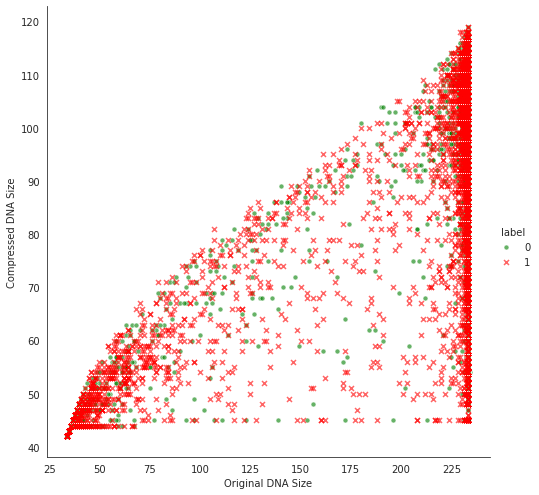

In [92]:
sns.set_style("white")

pal = {
    0: 'green',
    1: 'red'
}

g = sns.FacetGrid(tr, hue='label', palette=pal, height=7, hue_kws=dict(marker=["o", "x"]))
g.map(plt.scatter, "original_dna_size", "compressed_dna_size", s=25, alpha=.6, edgecolor="white")
g.add_legend()
g.set_axis_labels('Original DNA Size', 'Compressed DNA Size')

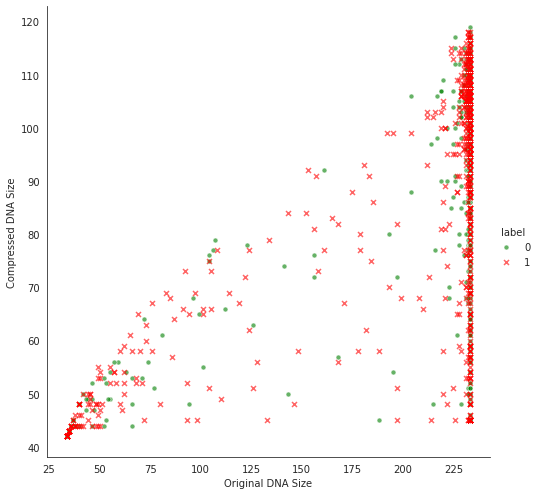

In [93]:
sns.set_style("white")

pal = {
    0: 'green',
    1: 'red'
}

g = sns.FacetGrid(te, hue='label', palette=pal, height=7, hue_kws=dict(marker=["o", "x"]))
g.map(plt.scatter, "original_dna_size", "compressed_dna_size", s=25, alpha=.6, edgecolor="white")
g.add_legend()
g.set_axis_labels('Original DNA Size', 'Compressed DNA Size')

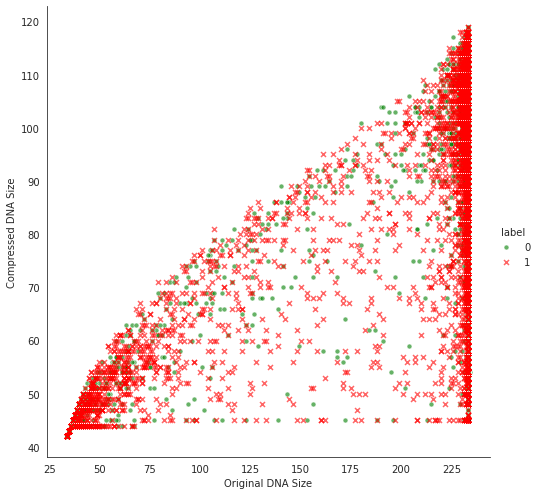

In [94]:
sns.set_style("white")

pal = {
    0: 'green',
    1: 'red'
}

g = sns.FacetGrid(all, hue='label', palette=pal, height=7, hue_kws=dict(marker=["o", "x"]))
g.map(plt.scatter, "original_dna_size", "compressed_dna_size", s=25, alpha=.6, edgecolor="white")
g.add_legend()
g.set_axis_labels('Original DNA Size', 'Compressed DNA Size')

##### Plot of DNA Size vs. Compression Ratio.

Includes the following accounts:
1. Genuine users
1. Social Spambots \#1
1. Social Spambots \#2
1. Social Spambots \#3
1. Traditional Spambots \#1

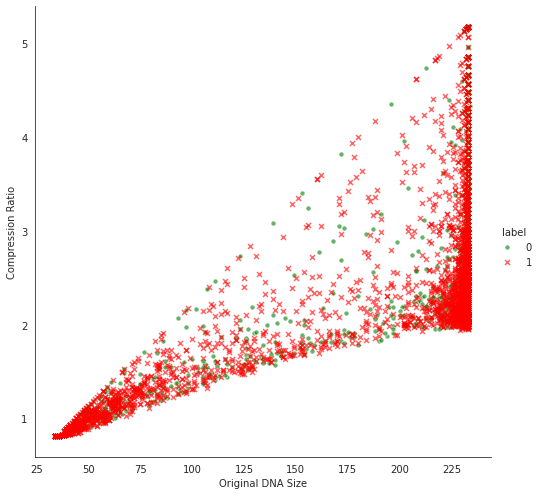

In [95]:
sns.set_style("white")

pal = {
    0: 'green',
    1: 'red'
}

g = sns.FacetGrid(tr, hue='label', palette=pal, size=7, hue_kws=dict(marker=["o", "x"]))
g.map(plt.scatter, "original_dna_size", "compression_ratio", s=25, alpha=.6, edgecolor="white")
g.add_legend()
g.set_axis_labels('Original DNA Size', 'Compression Ratio')

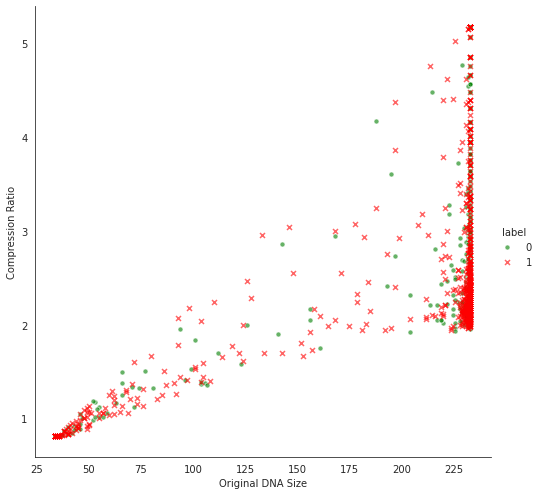

In [96]:
sns.set_style("white")

pal = {
    0: 'green',
    1: 'red'
}

g = sns.FacetGrid(te, hue='label', palette=pal, size=7, hue_kws=dict(marker=["o", "x"]))
g.map(plt.scatter, "original_dna_size", "compression_ratio", s=25, alpha=.6, edgecolor="white")
g.add_legend()
g.set_axis_labels('Original DNA Size', 'Compression Ratio')

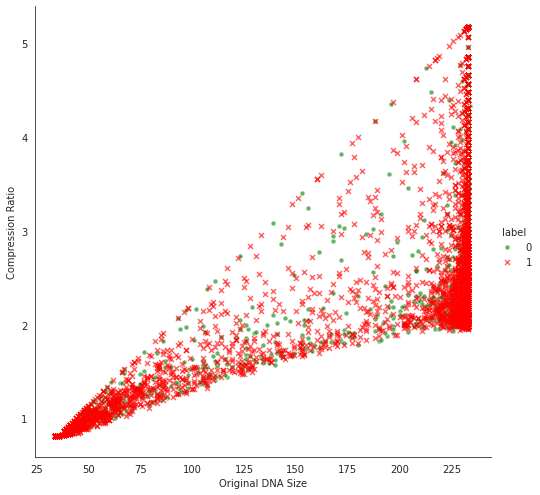

In [97]:
sns.set_style("white")

pal = {
    0: 'green',
    1: 'red'
}

g = sns.FacetGrid(all, hue='label', palette=pal, size=7, hue_kws=dict(marker=["o", "x"]))
g.map(plt.scatter, "original_dna_size", "compression_ratio", s=25, alpha=.6, edgecolor="white")
g.add_legend()
g.set_axis_labels('Original DNA Size', 'Compression Ratio')

##### Historgram for Compression Ratio

Includes the following accounts:
1. Genuine users
1. Social Spambots \#1
1. Social Spambots \#2
1. Social Spambots \#3
1. Traditional Spambots \#1

In [98]:
tr['compression_ratio'].describe()

count    8223.000000
mean        2.422052
std         0.924374
min         0.809524
25%         2.062500
50%         2.262136
75%         2.647727
max         5.177778
Name: compression_ratio, dtype: float64

In [99]:
te['compression_ratio'].describe()

count    1173.000000
mean        2.465922
std         0.964832
min         0.809524
25%         2.080357
50%         2.284314
75%         2.728395
max         5.177778
Name: compression_ratio, dtype: float64

In [100]:
all['compression_ratio'].describe()

count    9396.000000
mean        2.427529
std         0.929581
min         0.809524
25%         2.067147
50%         2.262136
75%         2.647727
max         5.177778
Name: compression_ratio, dtype: float64

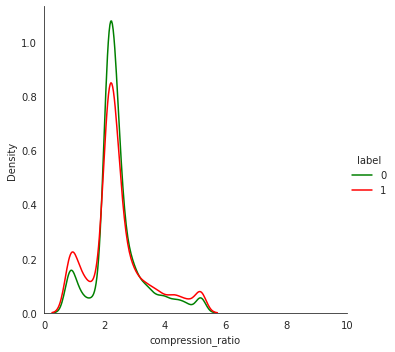

In [101]:
g = sns.FacetGrid(tr, hue='label', palette=pal, size=5)
g.set(xlim=(0, 10))
g.map(sns.kdeplot, 'compression_ratio')
g.add_legend()

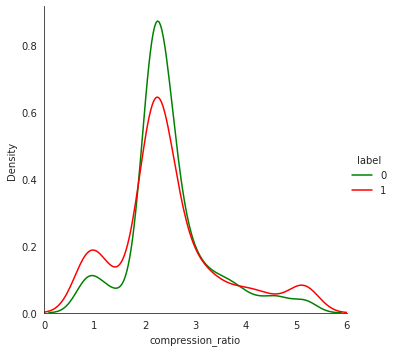

In [102]:
g = sns.FacetGrid(te, hue='label', palette=pal, size=5)
g.set(xlim=(0, 6))
g.map(sns.kdeplot, 'compression_ratio')
g.add_legend()

ValueError: ignored

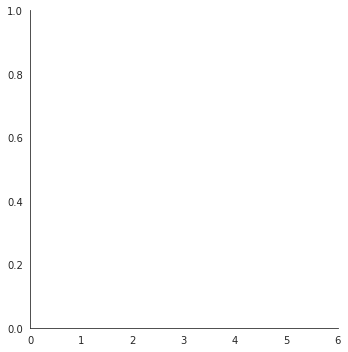

In [103]:
# g = sns.FacetGrid(all, hue='label', palette=pal, size=5)
# g.set(xlim=(0, 6))
# g.map(sns.kdeplot, 'compression_ratio')
# g.add_legend()

In [104]:
def evaluate(y_test, predictions):
    '''Return a dataframe with accuracy, precision, recall and f1 scores for predictions.'''
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    specificity = tn / (tn+fp)
    
    results = [
        {
            'Metric': 'Accuracy',
            'Score': accuracy_score(y_test, predictions)
        },
        {
            'Metric': 'Precision',
            'Score': precision_score(y_test, predictions)
        },
        {
            'Metric': 'Recall',
            'Score': recall_score(y_test, predictions)
        },
        {
            'Metric': 'F1 Score',
            'Score': f1_score(y_test, predictions)
        },
        {
            'Metric': 'MCC',
            'Score': matthews_corrcoef(y_test, predictions)
        },
        {
            'Metric': 'Specificity',
            'Score': specificity
        },
    ]

    return pd.DataFrame(results)

In [105]:
def train_predict_evaluate(dna, features, test_size=0.5):
    '''Train a Logistic Regression model with given features
    using default parameters on a random sample of data.'''

    # Randomly shuffle the dna dataframe.
    dna = utils.shuffle(dna)

    # Features and labels.
    X = dna[features]
    y = dna.loc[:, 'label']

    # Split the dataset for training and testing using Logistic Regression.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # Logistic Regression classifier with default parameters.
    classifier = LogisticRegression()

    # Train the classifier.
    start_train = time.time()
    classifier.fit(X_train, y_train)
    end_train = time.time()

    # Make predictions on the test set.
    start_test = time.time()
    predictions = classifier.predict(X_test)
    end_test = time.time()

    # Evaluation on the test set.
    results = evaluate(y_test, predictions)

    return results

In [106]:
k_common_substring_2 = pd.DataFrame({'Supervised': [0.970, 0.970, 0.940, 0.978, 0.961, 0.979], 
                                     'Unsupervised': [0.929, 0.923, 0.867, 1.000, 0.858, 1.000]},
                                    index=['Accuracy', 'F1 Score', 'MCC', 'Precision', 'Recall', 'Specificity'])

In [107]:
k_common_substring_1 = pd.DataFrame({'Supervised': [0.977, 0.977, 0.955, 0.982, 0.977, 0.981],
                                     'Unsupervised': [0.976, 0.977, 0.952, 0.982, 0.972, 0.981]}, 
                                    index=['Accuracy', 'F1 Score', 'MCC', 'Precision', 'Recall', 'Specificity'])


1. Logistic Regression with Original DNA Size + Compressed DNA Size

In [108]:
results = pd.DataFrame()

for i in range(1000):
    np.random.seed(i)
    results = pd.concat([results, train_predict_evaluate(tr, ['original_dna_size', 'compressed_dna_size'])])

# Compute average scores for each metric
results_with_length = results.groupby(by=['Metric']) \
               .mean() \
               .rename({'Score': 'Mean'}, axis=1) \
               .join(results.groupby(by=['Metric'])
                            .std() \
                            .rename({'Score': 'Std.'}, axis=1))

# Compute statistical significance against the method k-common-substring for DNA sequences
stat_sig = []
for metric in k_common_substring_1.index:
    s = dict()

    ts, ps = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_1['Supervised'][metric])
    tu, pu = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_1['Unsupervised'][metric])

    s['Metric'] = metric
    s['t-supervised'] = round(ts, 4)
    s['t-unsupervised'] = round(tu, 4)
    s['p-supervised'] = round(ps, 4)
    s['p-unsupervised'] = round(pu, 4)
    s['Mean'] = results[results['Metric'] == metric]['Score'].mean()
    s['SD'] = results[results['Metric'] == metric]['Score'].std()
    s['k-supervised'] = k_common_substring_1['Supervised'][metric]
    s['k-unsupervised'] = k_common_substring_1['Unsupervised'][metric]
    
    stat_sig.append(s)

stat_sig = pd.DataFrame(stat_sig).set_index(['Metric'])

stat_sig

,t-supervised,t-unsupervised,p-supervised,p-unsupervised,Mean,SD,k-supervised,k-unsupervised
Metric,,,,,,,,
Accuracy,-2229.2177,-2223.8388,0.0,0.0,0.562561,0.005879,0.977,0.976
F1 Score,-529.1305,-529.1305,0.0,0.0,0.691732,0.017049,0.977,0.977
MCC,-1364.0031,-1359.4813,0.0,0.0,0.050050,0.020980,0.955,0.952
Precision,-1192.6579,-1192.6579,0.0,0.0,0.573896,0.010821,0.982,0.982
Recall,-43.8826,-41.7148,0.0,0.0,0.875782,0.072940,0.977,0.972
Specificity,-287.1214,-287.1214,0.0,0.0,0.160310,0.090389,0.981,0.981


2. Logistic Regression with Original DNA Size + Compression Ratio

In [109]:
results = pd.DataFrame()
for i in range(1000):
    np.random.seed(i)
    results = pd.concat([results, train_predict_evaluate(tr, ['original_dna_size', 'compression_ratio'])])

# Compute average scores for each metric
results_with_ratio = results.groupby(by=['Metric']) \
               .mean() \
               .rename({'Score': 'Mean'}, axis=1) \
               .join(results.groupby(by=['Metric'])
                            .std() \
                            .rename({'Score': 'Std.'}, axis=1))

# Compute statistical significance against the method k-common-substring for DNA sequences
stat_sig = []
for metric in k_common_substring_1.index:
    s = dict()

    ts, ps = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_1['Supervised'][metric])
    tu, pu = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_1['Unsupervised'][metric])

    s['Metric'] = metric
    s['t-supervised'] = round(ts, 4)
    s['t-unsupervised'] = round(tu, 4)
    s['p-supervised'] = round(ps, 4)
    s['p-unsupervised'] = round(pu, 4)
    s['Mean'] = results[results['Metric'] == metric]['Score'].mean()
    s['SD'] = results[results['Metric'] == metric]['Score'].std()
    s['k-supervised'] = k_common_substring_1['Supervised'][metric]
    s['k-unsupervised'] = k_common_substring_1['Unsupervised'][metric]
    
    stat_sig.append(s)

stat_sig = pd.DataFrame(stat_sig).set_index(['Metric'])

stat_sig

,t-supervised,t-unsupervised,p-supervised,p-unsupervised,Mean,SD,k-supervised,k-unsupervised
Metric,,,,,,,,
Accuracy,-2119.7561,-2114.6269,0.0,0.0,0.563725,0.006165,0.977,0.976
F1 Score,-408.4501,-408.4501,0.0,0.0,0.693033,0.021985,0.977,0.977
MCC,-918.6844,-915.6403,0.0,0.0,0.049645,0.031164,0.955,0.952
Precision,-904.5406,-904.5406,0.0,0.0,0.574867,0.014233,0.982,0.982
Recall,-31.9775,-30.3008,0.0,0.0,0.881639,0.094303,0.977,0.972
Specificity,-215.2928,-215.2928,0.0,0.0,0.155949,0.121186,0.981,0.981


In [110]:
print('String Compression - Compressed DNA Size &',
      '{:.3f} &'.format(results_with_length['Mean']['Accuracy']),
      '{:.3f} &'.format(results_with_length['Mean']['Precision']),
      '{:.3f} &'.format(results_with_length['Mean']['Recall']),
      '{:.3f} &'.format(results_with_length['Mean']['F1 Score']),
      '{:.3f} &'.format(results_with_length['Mean']['MCC']),
      '{:.3f} \\\\'.format(results_with_length['Mean']['Specificity']))

print('String Compression - Compression Ratio &',
      '{:.3f} &'.format(results_with_ratio['Mean']['Accuracy']),
      '{:.3f} &'.format(results_with_ratio['Mean']['Precision']),
      '{:.3f} &'.format(results_with_ratio['Mean']['Recall']),
      '{:.3f} &'.format(results_with_ratio['Mean']['F1 Score']),
      '{:.3f} &'.format(results_with_ratio['Mean']['MCC']),
      '{:.3f} \\\\'.format(results_with_ratio['Mean']['Specificity']))

String Compression - Compressed DNA Size & 0.563 & 0.574 & 0.876 & 0.692 & 0.050 & 0.160 \\
String Compression - Compression Ratio & 0.564 & 0.575 & 0.882 & 0.693 & 0.050 & 0.156 \\


In [111]:
X_train = tr[['compressed_dna_size', 'original_dna_size', 'compression_ratio']]
y_train = tr.loc[:, 'label']

X_test = te[['compressed_dna_size', 'original_dna_size', 'compression_ratio']]
y_test = te.loc[:, 'label']
# Logistic Regression classifier with default parameters.
classifier = LogisticRegression()

# Train the classifier.
start_train = time.time()
classifier.fit(X_train, y_train)
end_train = time.time()

# Make predictions on the test set.
start_test = time.time()
predictions = classifier.predict(X_test)
end_test = time.time()

# Evaluation on the test set.
results = evaluate(y_test, predictions)


In [112]:
print(results)

        Metric     Score
0     Accuracy  0.540494
1    Precision  0.540494
2       Recall  1.000000
3     F1 Score  0.701716
4          MCC  0.000000
5  Specificity  0.000000


In [113]:
X_train = tr[['compressed_dna_size', 'original_dna_size']]
y_train = tr.loc[:, 'label']

X_test = te[['compressed_dna_size', 'original_dna_size']]
y_test = te.loc[:, 'label']
# Logistic Regression classifier with default parameters.
classifier = LogisticRegression()

# Train the classifier.
start_train = time.time()
classifier.fit(X_train, y_train)
end_train = time.time()

# Make predictions on the test set.
start_test = time.time()
predictions = classifier.predict(X_test)
end_test = time.time()

# Evaluation on the test set.
results = evaluate(y_test, predictions)

In [114]:
print(results)

        Metric     Score
0     Accuracy  0.542199
1    Precision  0.547133
2       Recall  0.888013
3     F1 Score  0.677090
4          MCC  0.035610
5  Specificity  0.135436


In [115]:
X_train = tr[['original_dna_size', 'compression_ratio']]
y_train = tr.loc[:, 'label']

X_test = te[['original_dna_size', 'compression_ratio']]
y_test = te.loc[:, 'label']
# Logistic Regression classifier with default parameters.
classifier = LogisticRegression()

# Train the classifier.
start_train = time.time()
classifier.fit(X_train, y_train)
end_train = time.time()

# Make predictions on the test set.
start_test = time.time()
predictions = classifier.predict(X_test)
end_test = time.time()

# Evaluation on the test set.
results = evaluate(y_test, predictions)

In [116]:
print(results)

        Metric     Score
0     Accuracy  0.542199
1    Precision  0.546411
2       Recall  0.900631
3     F1 Score  0.680167
4          MCC  0.033925
5  Specificity  0.120594


In [117]:
tr.isnull().any()

ID                     False
DNA                    False
original_dna_size      False
compressed_dna_size    False
compression_ratio      False
label                  False
dtype: bool

In [118]:
te.isnull().any()

ID                     False
DNA                    False
original_dna_size      False
compressed_dna_size    False
compression_ratio      False
label                  False
dtype: bool

In [119]:
tr['DNA'].value_counts()

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA    173
A                                                                                                                                                                                                            41
C                                                                                                                                                                                                            26
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT     26
T                                                                                                                                                                       

In [120]:
tr['DNA'] == ""

0       False
2       False
3       False
4       False
5       False
        ...  
8273    False
8274    False
8275    False
8276    False
8277    False
Name: DNA, Length: 8223, dtype: bool

In [121]:
tr

,ID,DNA,original_dna_size,compressed_dna_size,compression_ratio,label
0,17461978,TAAAAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAATATCTCAAAC...,233,100,2.330000,0
2,17685258,TATTTAATATAATTTTATATTTTTATTTAATTTAAAAATTATTATT...,233,101,2.306931,0
3,15750898,AAATTATTAATAATTATATTAAATTTAAATAATAAAATAATAATAT...,233,100,2.330000,0
4,1659167666,TTTTTTTTATTTAAAAAAAAAAATTTAATTAAAATTATTTTTTTTA...,121,66,1.833333,1
5,34743251,TTAAAAAAAAAATAAAAAATAAAAATTAAAATAAAATAAATAAAAA...,233,86,2.709302,0
...,...,...,...,...,...,...
8273,1630890068,CACACCCAACAACCAACAACAACACAAAAACACAAAAAACACCAAC...,233,102,2.284314,0
8274,713519580757536768,CCCCCACCCCCCCCCCAACCCCCCCCCCCCCCCTCCCCCTCCCCCT...,233,77,3.025974,1
8275,93345260,CAATCTACCCTATTTACCTTTTATTTTCTATTTATACTTTTTTTTT...,233,113,2.061947,1
8276,1749309397,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTCCCTCCCCCCCCC...,233,56,4.160714,1


In [122]:
all = utils.shuffle(all)
X = all[['original_dna_size', 'compression_ratio']]
y = all.loc[:, 'label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Logistic Regression classifier with default parameters.
classifier = LogisticRegression()

# Train the classifier.
start_train = time.time()
classifier.fit(X_train, y_train)
end_train = time.time()

# Make predictions on the test set.
start_test = time.time()
predictions = classifier.predict(X_test)
end_test = time.time()

# Evaluation on the test set.
results = evaluate(y_test, predictions)

In [123]:
print(results)

        Metric     Score
0     Accuracy  0.564496
1    Precision  0.575206
2       Recall  0.870517
3     F1 Score  0.692701
4          MCC  0.055203
5  Specificity  0.168863


In [124]:
all = utils.shuffle(all)
X = all[['compressed_dna_size', 'original_dna_size']]
y = all.loc[:, 'label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Logistic Regression classifier with default parameters.
classifier = LogisticRegression()

# Train the classifier.
start_train = time.time()
classifier.fit(X_train, y_train)
end_train = time.time()

# Make predictions on the test set.
start_test = time.time()
predictions = classifier.predict(X_test)
end_test = time.time()

# Evaluation on the test set.
results = evaluate(y_test, predictions)

In [125]:
print(results)

        Metric     Score
0     Accuracy  0.548957
1    Precision  0.576991
2       Recall  0.740629
3     F1 Score  0.648649
4          MCC  0.048145
5  Specificity  0.302868


In [126]:
# Feature Scaling for input features.
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statistics import mean, stdev
all = utils.shuffle(all)
x = all[['compressed_dna_size', 'original_dna_size']]
y = all.loc[:, 'label'].values
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
  
# Create  classifier object.
lr = LogisticRegression()
  
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
lst_accu_stratified = []
  
for train_index, test_index in skf.split(x, y):
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    lr.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(lr.score(x_test_fold, y_test_fold))
  
# Print the output.
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

List of possible accuracy: [0.5648936170212766, 0.5606382978723404, 0.5595744680851064, 0.5702127659574469, 0.5691489361702128, 0.5574468085106383, 0.5623003194888179, 0.5633652822151225, 0.5708200212992546, 0.5548455804046858]

Maximum Accuracy That can be obtained from this model is: 57.082002129925456 %

Minimum Accuracy: 55.48455804046858 %

Overall Accuracy: 56.33246097024902 %

Standard Deviation is: 0.005464893992515968


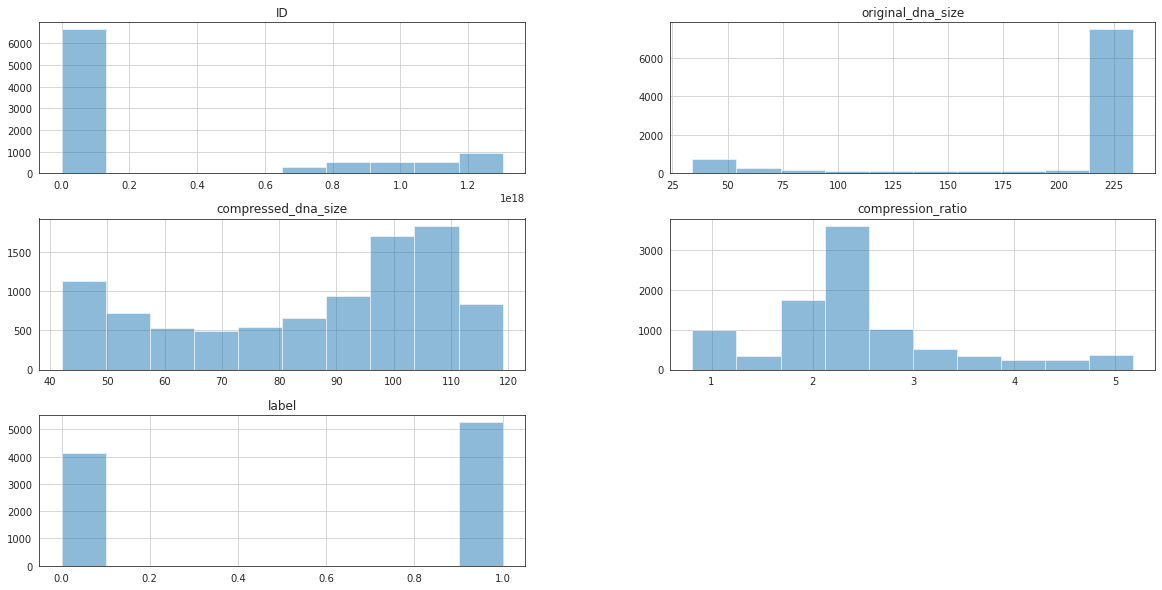

In [127]:
from matplotlib import pyplot
all.hist(alpha=0.5, figsize=(20, 10))
pyplot.show()

In [128]:
new_all = all.copy()
new_all['original_dna_size'] = np.log(new_all['original_dna_size'])
new_all['compressed_dna_size'] = np.log(new_all['compressed_dna_size'])

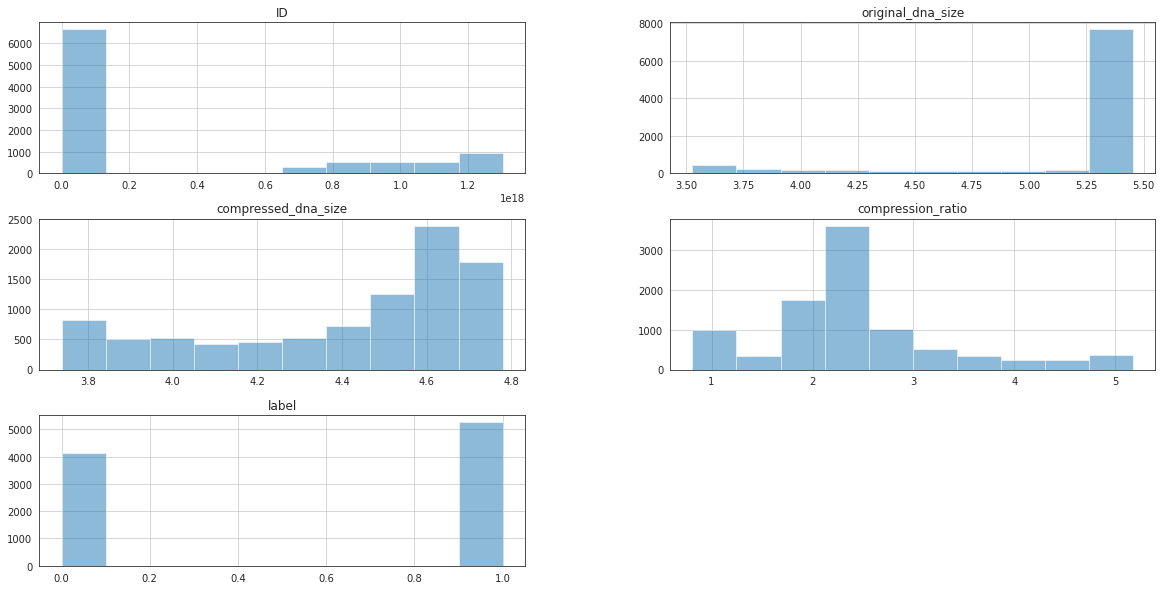

In [129]:
from matplotlib import pyplot
new_all.hist(alpha=0.5, figsize=(20, 10))
pyplot.show()

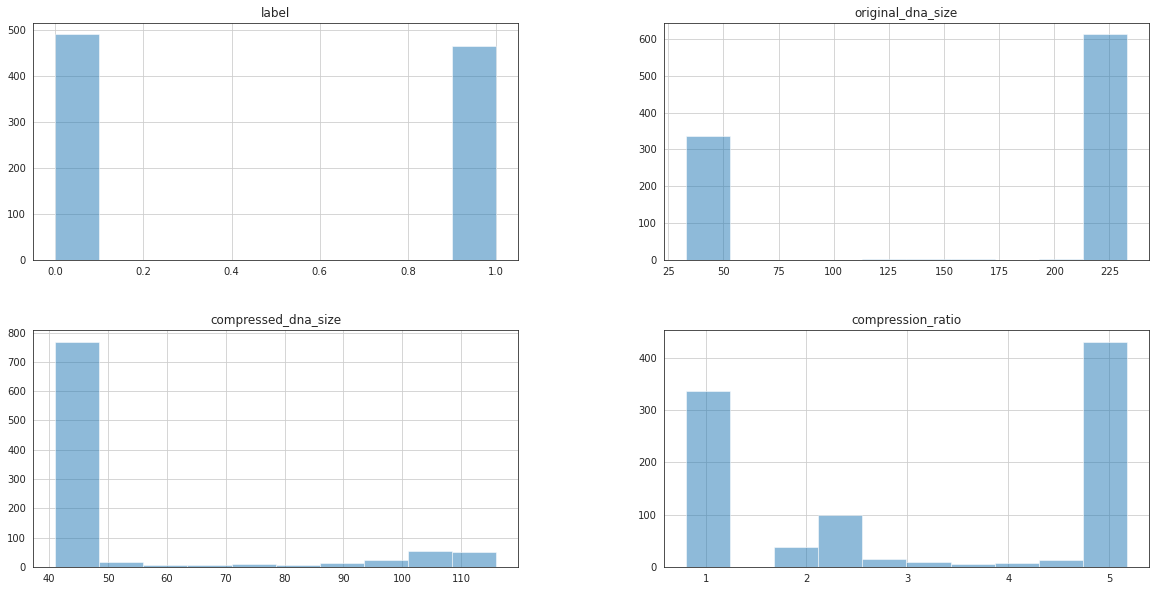

In [130]:
from matplotlib import pyplot
dna.hist(alpha=0.5, figsize=(20, 10))
pyplot.show()

In [131]:
all = utils.shuffle(all)
X = dna[['compressed_dna_size', 'original_dna_size']]
y = dna.loc[:, 'label'].values
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Logistic Regression classifier with default parameters.
classifier = LogisticRegression()

# Train the classifier.
start_train = time.time()
classifier.fit(X, y)
end_train = time.time()

X_test = all[['compressed_dna_size', 'original_dna_size']]
# Make predictions on the test set.
start_test = time.time()
predictions = classifier.predict(X_test)
end_test = time.time()
y_test = all.loc[:, 'label'].values

# Evaluation on the test set.
results = evaluate(y_test, predictions)

In [132]:
results

,Metric,Score
0,Accuracy,0.476266
1,Precision,0.605392
2,Recall,0.187654
3,F1 Score,0.286501
4,MCC,0.041610
5,Specificity,0.844106


In [133]:
all = utils.shuffle(all)
X = all[['compressed_dna_size', 'original_dna_size']]
y = all.loc[:, 'label'].values
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Logistic Regression classifier with default parameters.
classifier = LogisticRegression()

# Train the classifier.
start_train = time.time()
classifier.fit(X, y)
end_train = time.time()

X_test = dna[['compressed_dna_size', 'original_dna_size']]
# Make predictions on the test set.
start_test = time.time()
predictions = classifier.predict(X_test)
end_test = time.time()
y_test = dna.loc[:, 'label'].values

# Evaluation on the test set.
results = evaluate(y_test, predictions)

In [134]:
results

,Metric,Score
0,Accuracy,0.544025
1,Precision,0.516165
2,Recall,0.997845
3,F1 Score,0.680382
4,MCC,0.236454
5,Specificity,0.114286
